# Implementar o Conditional GAN

- Usar Conditional GAN: [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) com o dataset criado a partir de um grafo causal implícito

## Construir o Dataset

In [1]:
import numpy as np
import pandas as pd

![](../images/causal_graph.png)

In [2]:
n_samples = 60000
genero = np.random.choice([0,1],size=n_samples,p=[0.53,0.47]).reshape(n_samples,1)
idade = np.random.choice([0,1],size=n_samples,p=[0.65,0.35]).reshape(n_samples,1)
regiao = np.random.choice([0,1,2,3],size=n_samples,p=[0.2,0.3,0.4,0.1]).reshape(n_samples,1)

In [3]:
def gen_bigode(genero,idade):
    prob_bigode_velho = [0.4,0.6]
    prob_bigode_novo = [0.55,0.45]
    bigode = np.zeros(shape=(genero.shape[0],1))
    for i in range(genero.shape[0]):
        if genero[i] == 1 and idade[i]==1:
            bigode[i] = np.random.choice([0,1],p=prob_bigode_velho)
        elif genero[i] == 1 and idade[i]==0:
            bigode[i] = np.random.choice([0,1],p=prob_bigode_novo)
    return bigode

def gen_careca(genero,idade):
    prob_careca_velho = [0.3,0.7]
    prob_careca_novo = [0.8,0.2]
    careca = np.zeros(shape=(genero.shape[0],1))
    for i in range(genero.shape[0]):
        if genero[i] == 1 and idade[i]==1:
            careca[i] = np.random.choice([0,1],p=prob_careca_velho)
        if genero[i] == 1 and idade[i]==0:
            careca[i] = np.random.choice([0,1],p=prob_careca_novo)
    return careca

def gen_cabelo(regiao,careca):
    prob_cabelo_america = [0.45,0.40,0.15]
    prob_cabelo_europa = [0.35,0.40,0.25]
    prob_cabelo_asia = [0.9,0.09,0.01]
    prob_cabelo_oceania = [0.4,0.5,0.1]
    cabelo = np.zeros(shape=(regiao.shape[0],1))
    for i in range(regiao.shape[0]):
        if careca[i] == 0 and regiao[i]==0:
            cabelo[i] = np.random.choice([0,1,2],p=prob_cabelo_america)
        elif careca[i] == 0 and regiao[i]==1:
            cabelo[i] = np.random.choice([0,1,2],p=prob_cabelo_europa)
        elif careca[i] == 0 and regiao[i]==2:
            cabelo[i] = np.random.choice([0,1,2],p=prob_cabelo_asia)
        elif careca[i] == 0 and regiao[i]==3:
            cabelo[i] = np.random.choice([0,1,2],p=prob_cabelo_oceania)
        elif careca[i] == 1:
            cabelo[i] = 3
    return cabelo

def gen_oculos(idade):
    prob_oculos_velho = [0.4,0.6]
    prob_oculos_novo = [0.8,0.2]
    oculos = np.zeros(shape=(idade.shape[0],1))
    for i in range(idade.shape[0]):
        if idade[i] == 1:
            oculos[i] = np.random.choice([0,1],p=prob_oculos_velho)
        elif idade[i] == 0:
            oculos[i] = np.random.choice([0,1],p=prob_oculos_novo)
    return oculos

In [4]:
bigode = gen_bigode(genero,idade)
oculos = gen_oculos(idade)
careca = gen_careca(genero,idade)
cabelo = gen_cabelo(regiao,careca)

In [5]:
X_features = np.concatenate((genero,idade,cabelo,regiao,oculos,bigode,careca),axis=1)

In [6]:
df_num_ = pd.DataFrame(data=X_features,columns=['genero','idade','cabelo','regiao','oculos','bigode','careca']).astype(int)
df_num = df_num_[['genero','idade','oculos','bigode','careca']].copy()

In [7]:
df_num = pd.concat([df_num,pd.get_dummies(df_num_['regiao'],prefix='regiao',prefix_sep='_')],axis=1)
df_num = pd.concat([df_num,pd.get_dummies(df_num_['cabelo'],prefix='cabelo',prefix_sep='_')],axis=1)

In [8]:
df_num.head(2)

,genero,idade,oculos,bigode,careca,regiao_0,regiao_1,regiao_2,regiao_3,cabelo_0,cabelo_1,cabelo_2,cabelo_3
0,1,0,0,0,1,0,1,0,0,0,0,0,1
1,1,0,1,0,0,0,0,1,0,1,0,0,0


In [9]:
tradutor = {"genero":{0:"mulher",1:"homem"},
           "idade":{0:"novo",1:"velho"},
            "cabelo":{0:"escuro",1:"claro",2:"vermelho",3:"ausente"},
            "regiao":{0:"america",1:"europa",2:"asia",3:"oceania"},
            "oculos":{0:"sem oculos",1:"com oculos"},
            "bigode":{0:"sem bigode",1:"com bigode"},
            "careca":{0:"nao",1:"sim"}
           }

In [10]:
df_text = df_num_.copy()

In [11]:
for col in df_num_.columns:
    df_text[col] = df_num_[col].map(tradutor[col])

In [12]:
df_text.head()

,genero,idade,cabelo,regiao,oculos,bigode,careca
0,homem,novo,ausente,europa,sem oculos,sem bigode,sim
1,homem,novo,escuro,asia,com oculos,sem bigode,nao
2,homem,novo,escuro,asia,com oculos,sem bigode,nao
3,mulher,novo,escuro,asia,sem oculos,sem bigode,nao
4,mulher,velho,escuro,asia,sem oculos,sem bigode,nao


In [13]:
print(f"Mulheres com bigode: {df_num[(df_num['genero']==0)&(df_num['bigode']==1)].shape[0]}")
print(f"Mulheres carecas: {df_num[(df_num['genero']==0)&(df_num['careca']==1)].shape[0]}")
print(f"Carecas com cabelo: {df_num[(df_num['careca']==1)&(df_num['cabelo_3']!=1)].shape[0]}")

Mulheres com bigode: 0
Mulheres carecas: 0
Carecas com cabelo: 0


---
### Funções de auxílio

In [14]:
def plot_losses(losses_his):
    plt.figure(figsize=(20,8))
    plt.subplot(221)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador')
    plt.subplot(222)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador')
    plt.subplot(223)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: D real')
    plt.subplot(224)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: D fake')
#     plt.savefig('images/losses_plot',quality=100)
    plt.show()

---

## ConditionalGAN

- Label: usaremos apenas um label, `bigode`.
- Gerador: receberá o ruído `z` e a label `y` e retornará o dado `G(z,y)`.
- Discriminador: receberá `G(z,y)` e `z` e retornará a probabilidade do dado ser real.

In [15]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# probabilidade de ocorre bigode=1 no dataset
rho = df_num[df_num["bigode"]==1].shape[0]/df_num.shape[0]
rho

0.23728333333333335

In [17]:
X_data = df_num.drop("bigode",axis=1).copy().values
y_data = pd.get_dummies(df_num["bigode"]).values.reshape(X_data.shape[0],2)
X_tc = torch.Tensor(X_data).type(torch.FloatTensor)
y_tc = torch.Tensor(y_data).type(torch.FloatTensor)
print(X_tc.shape, X_tc.type(),y_tc.shape, y_tc.type())

torch.Size([60000, 12]) torch.FloatTensor torch.Size([60000, 2]) torch.FloatTensor


In [19]:
Z_dim,h_dim,X_dim,y_dim = [100,50,X_tc.shape[1],y_tc.shape[1]]

# Arquitetura do Gerador
class GNet(torch.nn.Module):
    def __init__(self):
        super(GNet,self).__init__()
        self.hidden = torch.nn.Linear(Z_dim+y_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, X_dim)
    
    def forward(self,z,l):
        h = F.relu(self.hidden(torch.cat((z,l),dim=1)))
        h = nn.Dropout(p=0.7)(h)
        X = torch.sigmoid(self.out(h))
        return X

# Arquitetura do Discriminador
class DNet(torch.nn.Module):
    def __init__(self):
        super(DNet,self).__init__()
        self.hidden = torch.nn.Linear(X_dim+y_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
    
    def forward(self,X,l):
        h = F.relu(self.hidden(torch.cat((X,l),dim=1)))
        h = nn.Dropout(p=0.7)(h)
        y = torch.sigmoid(self.out(h))
        return y

In [20]:
# Instanciamos as redes
G = GNet().cuda()
D = DNet().cuda()

# Definimos os otimizadores
lrg,lrd = [1e-3,1e-3]
G_optim = optim.Adam(G.parameters())
D_optim = optim.Adam(D.parameters())

def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()
    
batch = X_tc.shape[0]
ones  = Variable(torch.ones(batch, 1)).cuda()
zeros = Variable(torch.zeros(batch, 1)).cuda()
D_loss_real_func = nn.BCELoss()  
D_loss_fake_func = nn.BCELoss()
G_loss_func = nn.BCELoss()

def nets_test(n_sample,G,D):
    z = Variable(torch.randn(n_sample, Z_dim)).cuda()
    x = torch.Tensor(X_tc[:n_sample]).cuda()
    l = torch.Tensor(y_tc[:n_sample]).cuda()
    g = G(z,l)
    D_real = D(x,l)
    D_fake = D(g,l)
    print('Average D_real  {:.6f}| Std D_real  {:.6f}'.format(D_real.mean(),D_real.std()))
    print('Average D_fake  {:.6f}| Std D_fake  {:.6f}'.format(D_fake.mean(),D_fake.std()))

In [21]:
%%time
epochs = 10000

G_his, D_his, D_real_his, D_fake_his = [[],[],[],[]]
losses_his = [G_his,D_his,D_real_his,D_fake_his] 

for epoch in range(epochs):
    # Amostragem de dados
    z = Variable(torch.randn(batch, Z_dim)).cuda()
    X = X_tc.cuda()
    l = y_tc.cuda()
    # Dicriminador
    G_sample = G(z,l)
    D_real = D(X,l)
    D_fake = D(G_sample,l)
    D_loss_real = D_loss_real_func(D_real, ones)
    D_loss_fake = D_loss_fake_func(D_fake, zeros)
    D_loss = D_loss_real + D_loss_fake
    D_loss.backward()
    D_optim.step()
    reset_grad()
    # Generador
    z = Variable(torch.randn(batch, Z_dim)).cuda()
    G_sample = G(z,l)
    D_fake = D(G_sample,l)
    G_loss = G_loss_func(D_fake, ones)
    G_loss.backward()
    G_optim.step()
    reset_grad()
    # Recolher dados das funções de perda
    G_his.append(G_loss.data)
    D_his.append(D_loss.data)
    D_fake_his.append(D_loss_fake.data)
    D_real_his.append(D_loss_real.data)
    # Mostrar dados ao longo das epochs
    if epoch % int(epochs/4) == 0 and epoch > 0:
        print('Epoch-{}| Average D_loss: {:.5f}| Average G_loss: {:.5f}| Average D_real: {:.5f} | Average D_fake: {:.5f}'.format(
            epoch, D_loss.data, G_loss.data, D_loss_real.data, D_loss_fake.data))
        nets_test(20000,G,D)

Epoch-2500| Average D_loss: 1.31994| Average G_loss: 0.77941| Average D_real: 0.65784 | Average D_fake: 0.66210
Average D_real  0.525604| Std D_real  0.090603
Average D_fake  0.475087| Std D_fake  0.097876
Epoch-5000| Average D_loss: 1.34370| Average G_loss: 0.76036| Average D_real: 0.66781 | Average D_fake: 0.67589
Average D_real  0.516653| Std D_real  0.070921
Average D_fake  0.483307| Std D_fake  0.084937
Epoch-7500| Average D_loss: 1.34551| Average G_loss: 0.76895| Average D_real: 0.67119 | Average D_fake: 0.67433
Average D_real  0.515549| Std D_real  0.070378
Average D_fake  0.485526| Std D_fake  0.084335
CPU times: user 12min 50s, sys: 11.3 s, total: 13min 1s
Wall time: 13min 2s


In [22]:
nets_test(60000,G,D)

Average D_real  0.522507| Std D_real  0.079554
Average D_fake  0.485988| Std D_fake  0.088732


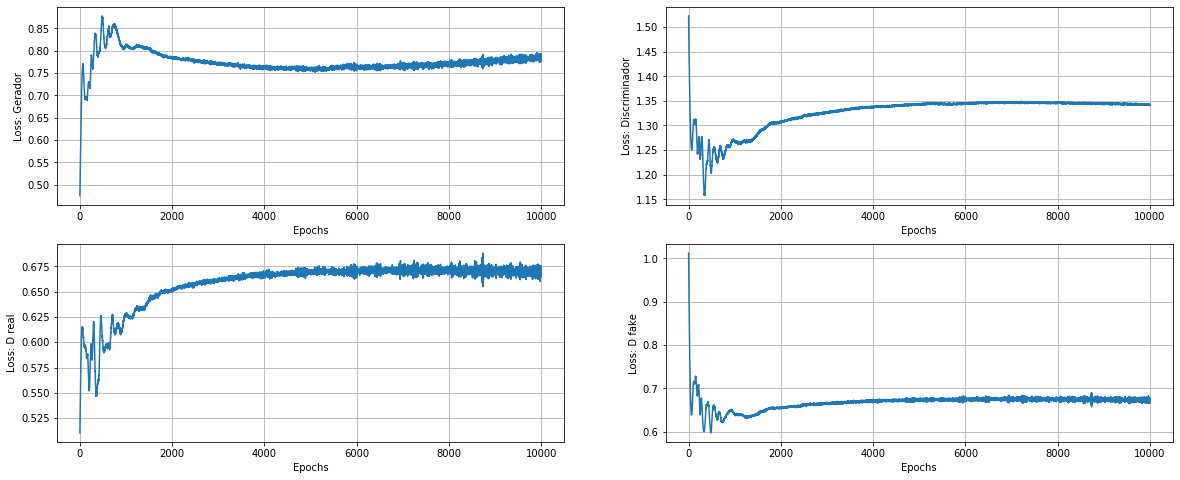

In [23]:
plot_losses(losses_his)

## Reproduzindo dados como os do dataset inicial

In [24]:
oh = np.eye(2)
batch = X_tc.shape[0]
l_s = np.random.choice([0,1],p=[1-rho,rho],size=(batch))
l_s_ = torch.Tensor(oh[l_s]).type(torch.FloatTensor).cuda()
l_s = torch.Tensor(l_s).type(torch.FloatTensor).reshape(batch,1).cuda()

In [25]:
g = G(Variable(torch.randn(batch, Z_dim)).cuda(),l_s_)
x_gen = torch.cat((g[:,0:3],l_s,g[:,3:]),dim=1)

In [26]:
df_g = pd.DataFrame(data=np.round(x_gen.cpu().data.numpy(),0),columns=df_num.columns).astype(int)

In [27]:
#dataset fake
print('mulheres de bigode: {}| homens de bigode: {}'\
      .format(df_g[(df_g['genero']==0)&(df_g['bigode']==1)].shape[0],
             df_g[(df_g['genero']==1)&(df_g['bigode']==1)].shape[0]))
print('novos de oculos: {}| velhos de oculos: {}'\
      .format(df_g[(df_g['idade']==0)&(df_g['oculos']==1)].shape[0],
             df_g[(df_g['idade']==1)&(df_g['oculos']==1)].shape[0]))

mulheres de bigode: 0| homens de bigode: 14293
novos de oculos: 8339| velhos de oculos: 12617


In [28]:
#dataset real
print('mulheres de bigode: {}| homens de bigode: {}'\
      .format(df_num[(df_num['genero']==0)&(df_num['bigode']==1)].shape[0],
             df_num[(df_num['genero']==1)&(df_num['bigode']==1)].shape[0]))
print('novos de oculos: {}| velhos de oculos: {}'\
      .format(df_num[(df_num['idade']==0)&(df_num['oculos']==1)].shape[0],
             df_num[(df_num['idade']==1)&(df_num['oculos']==1)].shape[0]))

mulheres de bigode: 0| homens de bigode: 14237
novos de oculos: 7802| velhos de oculos: 12613


In [29]:
#dataset fake
print('mulheres carecas: {}| homens carecas: {}'\
      .format(df_g[(df_g['genero']==0)&(df_g['careca']==1)].shape[0],
             df_g[(df_g['genero']==1)&(df_g['careca']==1)].shape[0]))
print('novos carecas: {}| velhos carecas: {}'\
      .format(df_g[(df_g['idade']==0)&(df_g['careca']==1)].shape[0],
             df_g[(df_g['idade']==1)&(df_g['careca']==1)].shape[0]))

mulheres carecas: 12| homens carecas: 10748
novos carecas: 3758| velhos carecas: 7002


In [30]:
#dataset real
print('mulheres carecas: {}| homens carecas: {}'\
      .format(df_num[(df_num['genero']==0)&(df_num['careca']==1)].shape[0],
             df_num[(df_num['genero']==1)&(df_num['careca']==1)].shape[0]))
print('novos carecas: {}| velhos carecas: {}'\
      .format(df_num[(df_num['idade']==0)&(df_num['careca']==1)].shape[0],
             df_num[(df_num['idade']==1)&(df_num['careca']==1)].shape[0]))

mulheres carecas: 0| homens carecas: 10742
novos carecas: 3746| velhos carecas: 6996


In [31]:
#dataset fake
print('proporcao de novos sem oculos: {:.4f}'\
      .format(df_g[(df_g['idade']==0)&(df_g['oculos']==0)].shape[0]/\
             df_g[df_g['idade']==0].shape[0]))
print('proporcao de velhos sem oculos: {:.4f}'\
      .format(df_g[(df_g['idade']==1)&(df_g['oculos']==0)].shape[0]/\
             df_g[df_g['idade']==1].shape[0]+0.001))

proporcao de novos sem oculos: 0.7879
proporcao de velhos sem oculos: 0.3910


In [32]:
#dataset real
print('proporcao de novos sem oculos: {:.4f}'\
      .format(df_num[(df_num['idade']==0)&(df_num['oculos']==0)].shape[0]/\
             df_num[df_num['idade']==0].shape[0]))
print('proporcao de velhos sem oculos: {:.4f}'\
      .format(df_num[(df_num['idade']==1)&(df_num['oculos']==0)].shape[0]/\
             df_num[df_num['idade']==1].shape[0]))

proporcao de novos sem oculos: 0.7996
proporcao de velhos sem oculos: 0.4011


In [33]:
for col in df_num.columns:
    print('variacao de {} em relacao ao real: {:.2%}'\
          .format(col,
                  (df_num[col].value_counts().values[0]-df_g[col].value_counts().values[0])/df_num[col].value_counts().values[0]))

variacao de genero em relacao ao real: 4.39%
variacao de idade em relacao ao real: -0.96%
variacao de oculos em relacao ao real: 1.37%
variacao de bigode em relacao ao real: 0.12%
variacao de careca em relacao ao real: 0.04%
variacao de regiao_0 em relacao ao real: -3.20%
variacao de regiao_1 em relacao ao real: -0.95%
variacao de regiao_2 em relacao ao real: 6.86%
variacao de regiao_3 em relacao ao real: -1.33%
variacao de cabelo_0 em relacao ao real: -5.12%
variacao de cabelo_1 em relacao ao real: -5.31%
variacao de cabelo_2 em relacao ao real: -1.18%
variacao de cabelo_3 em relacao ao real: 0.05%


In [ ]:
for col in df_g.columns:
    plt.figure(figsize=(10,3))
    sns.distplot(df_num[col],label='Real')
    sns.distplot(df_g[col],label='Fake')
    plt.legend(loc=0)
    plt.grid(True)
    plt.show()

## Intervenção

In [24]:
oh = np.eye(2)
batch = X_tc.shape[0]
l_s = np.random.choice([0,1],p=[0,1],size=(batch))
l_s_ = torch.Tensor(oh[l_s]).type(torch.FloatTensor).cuda()
l_s = torch.Tensor(l_s).type(torch.FloatTensor).reshape(batch,1).cuda()

In [25]:
g = G(Variable(torch.randn(batch, Z_dim)).cuda(),l_s_)
x_gen = torch.cat((g[:,0:3],l_s,g[:,3:]),dim=1)

In [26]:
df_g = pd.DataFrame(data=np.round(x_gen.cpu().data.numpy(),0),columns=df_num.columns).astype(int)

In [27]:
#dataset fake
print('mulheres de bigode: {}| homens de bigode: {}'\
      .format(df_g[(df_g['genero']==0)&(df_g['bigode']==1)].shape[0],
             df_g[(df_g['genero']==1)&(df_g['bigode']==1)].shape[0]))
print('novos de oculos: {}| velhos de oculos: {}'\
      .format(df_g[(df_g['idade']==0)&(df_g['oculos']==1)].shape[0],
             df_g[(df_g['idade']==1)&(df_g['oculos']==1)].shape[0]))

mulheres de bigode: 0| homens de bigode: 14293
novos de oculos: 8339| velhos de oculos: 12617


In [28]:
#dataset real
print('mulheres de bigode: {}| homens de bigode: {}'\
      .format(df_num[(df_num['genero']==0)&(df_num['bigode']==1)].shape[0],
             df_num[(df_num['genero']==1)&(df_num['bigode']==1)].shape[0]))
print('novos de oculos: {}| velhos de oculos: {}'\
      .format(df_num[(df_num['idade']==0)&(df_num['oculos']==1)].shape[0],
             df_num[(df_num['idade']==1)&(df_num['oculos']==1)].shape[0]))

mulheres de bigode: 0| homens de bigode: 14237
novos de oculos: 7802| velhos de oculos: 12613


In [29]:
#dataset fake
print('mulheres carecas: {}| homens carecas: {}'\
      .format(df_g[(df_g['genero']==0)&(df_g['careca']==1)].shape[0],
             df_g[(df_g['genero']==1)&(df_g['careca']==1)].shape[0]))
print('novos carecas: {}| velhos carecas: {}'\
      .format(df_g[(df_g['idade']==0)&(df_g['careca']==1)].shape[0],
             df_g[(df_g['idade']==1)&(df_g['careca']==1)].shape[0]))

mulheres carecas: 12| homens carecas: 10748
novos carecas: 3758| velhos carecas: 7002


In [30]:
#dataset real
print('mulheres carecas: {}| homens carecas: {}'\
      .format(df_num[(df_num['genero']==0)&(df_num['careca']==1)].shape[0],
             df_num[(df_num['genero']==1)&(df_num['careca']==1)].shape[0]))
print('novos carecas: {}| velhos carecas: {}'\
      .format(df_num[(df_num['idade']==0)&(df_num['careca']==1)].shape[0],
             df_num[(df_num['idade']==1)&(df_num['careca']==1)].shape[0]))

mulheres carecas: 0| homens carecas: 10742
novos carecas: 3746| velhos carecas: 6996


In [31]:
#dataset fake
print('proporcao de novos sem oculos: {:.4f}'\
      .format(df_g[(df_g['idade']==0)&(df_g['oculos']==0)].shape[0]/\
             df_g[df_g['idade']==0].shape[0]))
print('proporcao de velhos sem oculos: {:.4f}'\
      .format(df_g[(df_g['idade']==1)&(df_g['oculos']==0)].shape[0]/\
             df_g[df_g['idade']==1].shape[0]+0.001))

proporcao de novos sem oculos: 0.7879
proporcao de velhos sem oculos: 0.3910


In [32]:
#dataset real
print('proporcao de novos sem oculos: {:.4f}'\
      .format(df_num[(df_num['idade']==0)&(df_num['oculos']==0)].shape[0]/\
             df_num[df_num['idade']==0].shape[0]))
print('proporcao de velhos sem oculos: {:.4f}'\
      .format(df_num[(df_num['idade']==1)&(df_num['oculos']==0)].shape[0]/\
             df_num[df_num['idade']==1].shape[0]))

proporcao de novos sem oculos: 0.7996
proporcao de velhos sem oculos: 0.4011


In [33]:
for col in df_num.columns:
    print('variacao de {} em relacao ao real: {:.2%}'\
          .format(col,
                  (df_num[col].value_counts().values[0]-df_g[col].value_counts().values[0])/df_num[col].value_counts().values[0]))

variacao de genero em relacao ao real: 4.39%
variacao de idade em relacao ao real: -0.96%
variacao de oculos em relacao ao real: 1.37%
variacao de bigode em relacao ao real: 0.12%
variacao de careca em relacao ao real: 0.04%
variacao de regiao_0 em relacao ao real: -3.20%
variacao de regiao_1 em relacao ao real: -0.95%
variacao de regiao_2 em relacao ao real: 6.86%
variacao de regiao_3 em relacao ao real: -1.33%
variacao de cabelo_0 em relacao ao real: -5.12%
variacao de cabelo_1 em relacao ao real: -5.31%
variacao de cabelo_2 em relacao ao real: -1.18%
variacao de cabelo_3 em relacao ao real: 0.05%


In [ ]:
for col in df_g.columns:
    plt.figure(figsize=(10,3))
    sns.distplot(df_num[col],label='Real')
    sns.distplot(df_g[col],label='Fake')
    plt.legend(loc=0)
    plt.grid(True)
    plt.show()